# Offline A/B Testing for Recommender Systems

## 1. Background and Problem Definition

### 1.1. Background (User Story)

A streaming company currently uses a **popularity-based recommendation system** that suggests the same popular movies to all users. The data science team has developed a new **personalized ML-based recommender** using collaborative filtering that could improve user engagement.

### 1.2. Problem Definition

Deploying the new system directly to production poses significant risks:
- **Revenue loss** if recommendations perform worse
- **User churn** from poor experience
- **Wasted resources** if rollback is needed

The team needs to validate the new system's performance before production deployment through **offline A/B testing** using historical data.

### 1.3. Dataset

* **Source:** MovieLens 32M (2023) https://grouplens.org/datasets/movielens/32m/
* **Size:** 20,000 sampled users, 3.2 million ratings
* **Split:** 80% train / 20% test (temporal split)

### 1.4. References

**Gilotte, A., Calauzènes, C., Nedelec, T., Abraham, A., & Dollé, S. (2018).** Offline A/B testing for Recommender Systems. *Proceedings of the Eleventh ACM International Conference on Web Search and Data Mining (WSDM '18)*. https://doi.org/10.1145/3159652.3159687

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

## 2. Data Wrangling

### 2.1. Data Loading

We load the **MovieLens 32M dataset** containing user ratings for movies. The dataset includes:
* **userId:** Unique identifier for each user
* **movieId:** Unique identifier for each movie
* **rating:** User rating (0.5 to 5.0 scale)
* **timestamp:** When the rating was given
* **title:** Movie title with release year

**Sampling:** Due to computational constraints, we sampled **20,000 users** from the original 200,948 users, resulting in **3.2 million ratings**. This sampled dataset (`sampled_movie_data.csv`) maintains sufficient statistical power while enabling efficient processing.

This dataset represents historical user interactions that will be used to simulate the logging policy (Model A) and evaluate the new policy (Model B) offline.

In [2]:
# Load the pre-sampled dataset
data = pd.read_csv('sampled_movie_data.csv')

# Ensure timestamp is in datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

data.head()

,userId,movieId,rating,timestamp,title
0,1,17,4.0,1999-12-03 19:24:37,Sense and Sensibility (1995)
1,1,25,1.0,1999-12-03 19:43:48,Leaving Las Vegas (1995)
2,1,29,2.0,1999-11-22 00:36:16,"City of Lost Children, The (Cité des enfants p..."
3,1,30,5.0,1999-12-03 19:24:37,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
4,1,32,5.0,1999-11-22 00:00:58,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)


### 2.2. Train/Test Split

We perform a **temporal split** to simulate a realistic offline A/B testing scenario:

- **Train (80%):** Earlier ratings used to train both Model A and Model B
- **Test (20%):** Later ratings used to evaluate Model B's performance via IPS

**Why temporal split?** This mimics real-world deployment where we train on historical data and predict future user behavior, avoiding data leakage and ensuring valid evaluation.

In [3]:
# Sort data by time
data = data.sort_values('timestamp')

# Split data into Train (80%) and Test (20%)
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

print(f"Train data: {len(train_data)} ratings")
print(f"Test data: {len(test_data)} ratings")

Train data: 2544043 ratings
Test data: 636011 ratings


### 2.3. Model A: Popularity-Based Recommender (Baseline)

Model A represents a **traditional rule-based recommendation system** that recommends movies based on overall popularity:

- **Approach:** Rank movies by average rating (minimum 30 ratings for reliability)
- **Characteristic:** Non-personalized - all users receive similar recommendations
- **Role:** Simulates the existing "logging policy" that generated historical data

This simple baseline is commonly used in production systems and serves as our benchmark for comparison.

In [4]:
# Model A: Popularity-based Recommender
# Calculate popularity based on Train data
movie_avg_rating = train_data.groupby('title')['rating'].agg(['mean', 'count']).reset_index()
movie_avg_rating.columns = ['title', 'avg_rating', 'num_ratings']

# Filter movies with at least 30 ratings
movie_avg_rating = movie_avg_rating[movie_avg_rating['num_ratings'] >= 30]
movie_avg_rating = movie_avg_rating.sort_values('avg_rating', ascending=False)

# Recommendation function
def recommend_model_a(user_id, top_n=10):
    """
    Recommend top N popular movies based on Train data,
    excluding movies the user has already watched in Train data.
    """
    # Check if user exists in Train data to filter watched movies
    # (If user is new in Test data, they haven't watched anything in Train, so we recommend top popular)
    user_rated = []
    if user_id in train_data['userId'].values:
        user_rated = train_data[train_data['userId'] == user_id]['title'].unique()
    
    # Filter out already rated movies
    recommendations = movie_avg_rating[~movie_avg_rating['title'].isin(user_rated)]
    
    return recommendations.head(top_n)[['title', 'avg_rating']]

# Test Model A
recommend_model_a(user_id=1, top_n=10)

,title,avg_rating
18227,Planet Earth II (2016),4.449367
20761,"Shawshank Redemption, The (1994)",4.421286
18226,Planet Earth (2006),4.398551
27056,Whiplash (2013),4.386364
19163,Red Beard (Akahige) (1965),4.333333
9503,"Godfather, The (1972)",4.319698
26195,"Usual Suspects, The (1995)",4.304878
13042,Knockin' on Heaven's Door (1997),4.295455
10643,High and Low (Tengoku to jigoku) (1963),4.291667
1034,Ali: Fear Eats the Soul (Angst essen Seele auf...,4.287879


**Model A: Top Recommended Movies**

Model A recommends highly-rated popular movies consistently to all users:
- Planet Earth II (4.45)
- Shawshank Redemption (4.42)
- Godfather (4.32)

**Characteristic:** Non-personalized baseline that ignores individual user preferences.

### 2.4. Model B: SVD-Based Collaborative Filtering (Proposed)

Model B represents a **machine learning-based personalized recommender system** using Singular Value Decomposition (SVD):

- **Approach:** Matrix factorization to discover latent user preferences and movie characteristics
- **Characteristic:** Personalized - each user receives tailored recommendations based on their taste
- **Advantage:** Captures hidden patterns in user-movie interactions beyond simple popularity

**Key Parameters:**
- n_components = 20 (latent factors)
- Trained on user-item interaction matrix from training data

This advanced approach aims to improve user satisfaction through personalization.

In [5]:
# Model B: Matrix Factorization (SVD)
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Create user-item matrix (Using ONLY Train data)
user_item_matrix = train_data.pivot_table(index='userId', columns='title', values='rating')
user_item_matrix = user_item_matrix.fillna(0)

# Apply SVD
n_components = 20
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_features = svd.fit_transform(user_item_matrix)
item_features = svd.components_

print(f"User features shape: {user_features.shape}")
print(f"Item features shape: {item_features.shape}")

User features shape: (17104, 20)
Item features shape: (20, 27956)


In [6]:
# Model B: SVD Recommendation function (with normalization)
def recommend_model_b(user_id, top_n=10):
    """
    Recommend top N movies using SVD-based collaborative filtering
    """
    # Cold Start Issue: Check if user exists in the training data
    if user_id not in user_item_matrix.index:
        return pd.DataFrame(columns=['title', 'predicted_rating'])

    # Get user index
    user_idx = user_item_matrix.index.get_loc(user_id)
    
    # Predict ratings for all movies
    user_vector = user_features[user_idx].reshape(1, -1)
    predicted_ratings = user_vector @ item_features
    
    # Normalize predicted ratings to 0.5-5.0 scale
    min_pred = predicted_ratings.min()
    max_pred = predicted_ratings.max()
    predicted_ratings_normalized = 0.5 + (predicted_ratings - min_pred) / (max_pred - min_pred) * 4.5
    
    # Get movie titles
    movie_titles = user_item_matrix.columns
    predictions = pd.DataFrame({
        'title': movie_titles,
        'predicted_rating': predicted_ratings_normalized[0]
    })
    
    # Filter out already rated movies (Using TRAIN data to prevent leakage)
    user_rated = train_data[train_data['userId'] == user_id]['title'].unique()
    recommendations = predictions[~predictions['title'].isin(user_rated)]
    
    return recommendations.sort_values('predicted_rating', ascending=False).head(top_n)

# Test Model B
recommend_model_b(user_id=1, top_n=10)

,title,predicted_rating
9503,"Godfather, The (1972)",4.702811
18984,Raiders of the Lost Ark (Indiana Jones and the...,4.197984
17247,One Flew Over the Cuckoo's Nest (1975),3.974470
13158,L.A. Confidential (1997),3.950623
1054,Alien (1979),3.717450
1286,American Beauty (1999),3.703517
179,2001: A Space Odyssey (1968),3.681238
18752,Pulp Fiction (1994),3.610832
6979,Dr. Strangelove or: How I Learned to Stop Worr...,3.608404
26195,"Usual Suspects, The (1995)",3.523613


### 2.5. Model B: Personalized Recommendations (User 1)

Model B provides personalized recommendations tailored to User 1's preferences:
- Godfather (4.70 predicted rating)
- Raiders of the Lost Ark (4.20)
- One Flew Over the Cuckoo's Nest (3.97)

**Key difference:** Unlike Model A's generic popular movies, Model B uses SVD to predict ratings based on User 1's historical preferences and similar users' behavior, resulting in a unique recommendation list for each user.

## 3. EDA (Exploratory Data Analysis)

### 3.1. Model A: Probability Distribution (Top 20)

The probability distribution shows Model A's recommendation pattern:
- Highest probability: Planet Earth II (0.0009)
- Probabilities are concentrated on a small set of popular movies
- Non-personalized: same probabilities apply to all users regardless of individual preferences

This visualization sets the baseline for comparison with Model B's personalized approach.

Model A Probability Example (Top 5):
title
Planet Earth II (2016)              0.000911
Shawshank Redemption, The (1994)    0.000861
Planet Earth (2006)                 0.000823
Whiplash (2013)                     0.000803
Red Beard (Akahige) (1965)          0.000722
dtype: float64


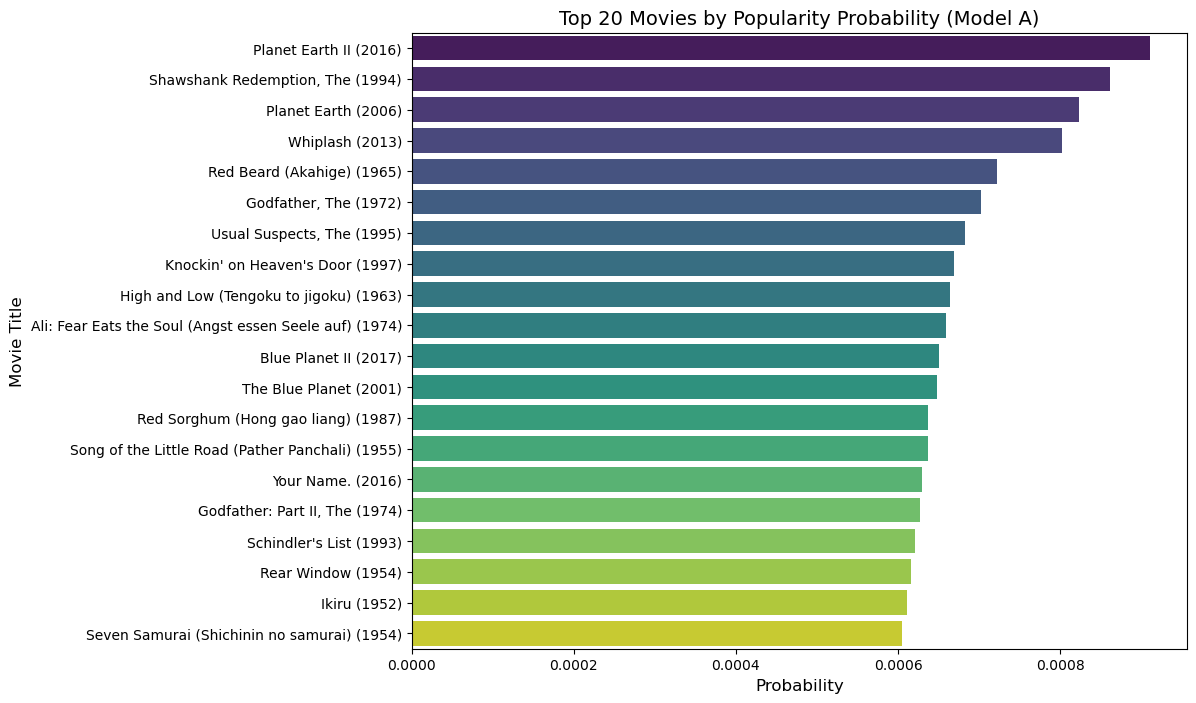

In [8]:
# Softmax Helper Function
def get_softmax_probs(scores, temperature=1.0):
    """
    Convert scores to probabilities using Softmax
    temperature: Controls distribution sharpness (lower = more peaked)
    """
    scores = np.array(scores)
    exp_scores = np.exp((scores - np.max(scores)) / temperature)
    return exp_scores / np.sum(exp_scores)

# Model A (Popularity) Probability Calculation
pop_scores = movie_avg_rating.set_index('title')['avg_rating']

# Convert scores to probabilities (P(A))
model_a_probs = pd.Series(
    get_softmax_probs(pop_scores.values, temperature=0.5),
    index=pop_scores.index
)
print("Model A Probability Example (Top 5):")
print(model_a_probs.sort_values(ascending=False).head())

# Model A Probability Visualization - Top 20 Movies
top_n = 20
top_probs = model_a_probs.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_probs.values, y=top_probs.index, palette='viridis')
plt.title(f'Top {top_n} Movies by Popularity Probability (Model A)', fontsize=14)
plt.xlabel('Probability', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()

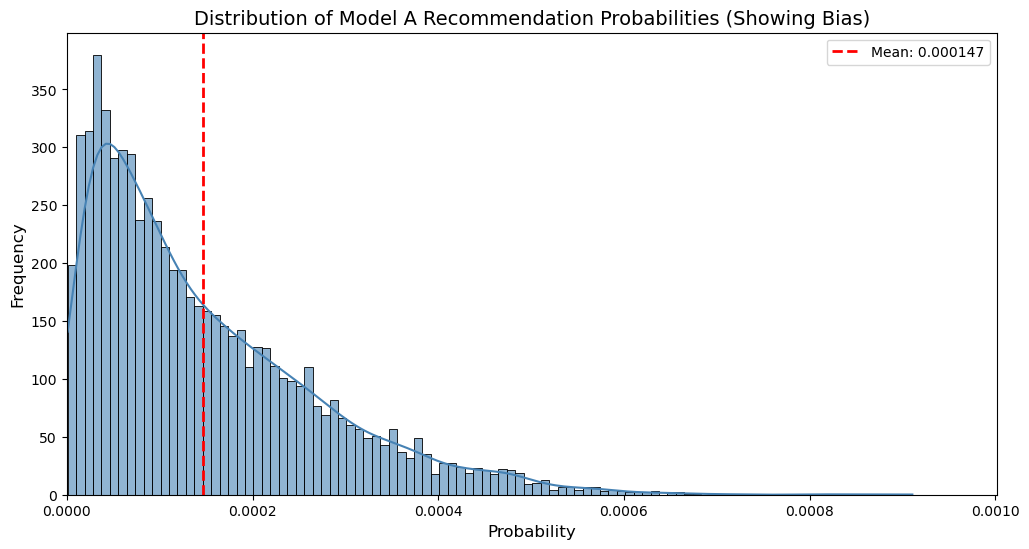

In [9]:
# Visualize distribution of Model A probabilities (KDE + Histogram)
plt.figure(figsize=(12, 6))

# Plot histogram with KDE
sns.histplot(model_a_probs, bins=100, kde=True, color='steelblue', alpha=0.6)
plt.axvline(model_a_probs.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {model_a_probs.mean():.6f}')

plt.title('Distribution of Model A Recommendation Probabilities (Showing Bias)', fontsize=14)
plt.xlabel('Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.xlim(0, model_a_probs.max() * 1.1)
plt.show()

**Model A Bias Analysis**

The distribution shows **extreme bias** in Model A's recommendations:
- Most movies have near-zero recommendation probability (left side)
- Only a small subset of popular movies dominate recommendations (right tail)
- Mean probability (0.000147) is skewed right by a few highly-recommended items

**Conclusion:** Model A lacks diversity and personalization, repeatedly recommending the same popular movies while ignoring the majority of the catalog.

### 3.2. Model B: Probability Distribution (Top 20)

Model B's averaged probability distribution across 100 sample users shows:
- More diverse recommendations compared to Model A
- Top movie: Inception (0.05 probability)
- Mix of blockbusters and varied genres (Sci-Fi, Drama, Action)

**Key observation:** While still showing some concentration on popular films, Model B exhibits greater diversity than Model A, reflecting personalization effects averaged across users.

In [17]:
# Model B (SVD) Probability Calculation Function
def get_model_b_probs(user_id, temperature=0.5):
    """
    Returns movie probabilities for a specific user using Model B
    """
    # Cannot calculate for new users not in training set
    if user_id not in user_item_matrix.index:
        return None
    
    user_idx = user_item_matrix.index.get_loc(user_id)
    
    # Predict ratings for all movies using SVD
    user_vector = user_features[user_idx].reshape(1, -1)
    predicted_ratings = user_vector @ item_features
    predicted_ratings = predicted_ratings.flatten()
    
    # Apply Softmax to convert to probabilities
    probs = get_softmax_probs(predicted_ratings, temperature=temperature)
    
    return pd.Series(probs, index=user_item_matrix.columns)
    
# Get unique test users
unique_test_users = test_data['userId'].unique()

# Calculate average probability for Model B across sample users
sample_users_viz = unique_test_users[:100] 
model_b_avg_probs = pd.Series(0.0, index=user_item_matrix.columns)

for uid in sample_users_viz:
    p_b = get_model_b_probs(uid, temperature=0.5)
    if p_b is not None:
        model_b_avg_probs += p_b
        
model_b_avg_probs /= len(sample_users_viz)

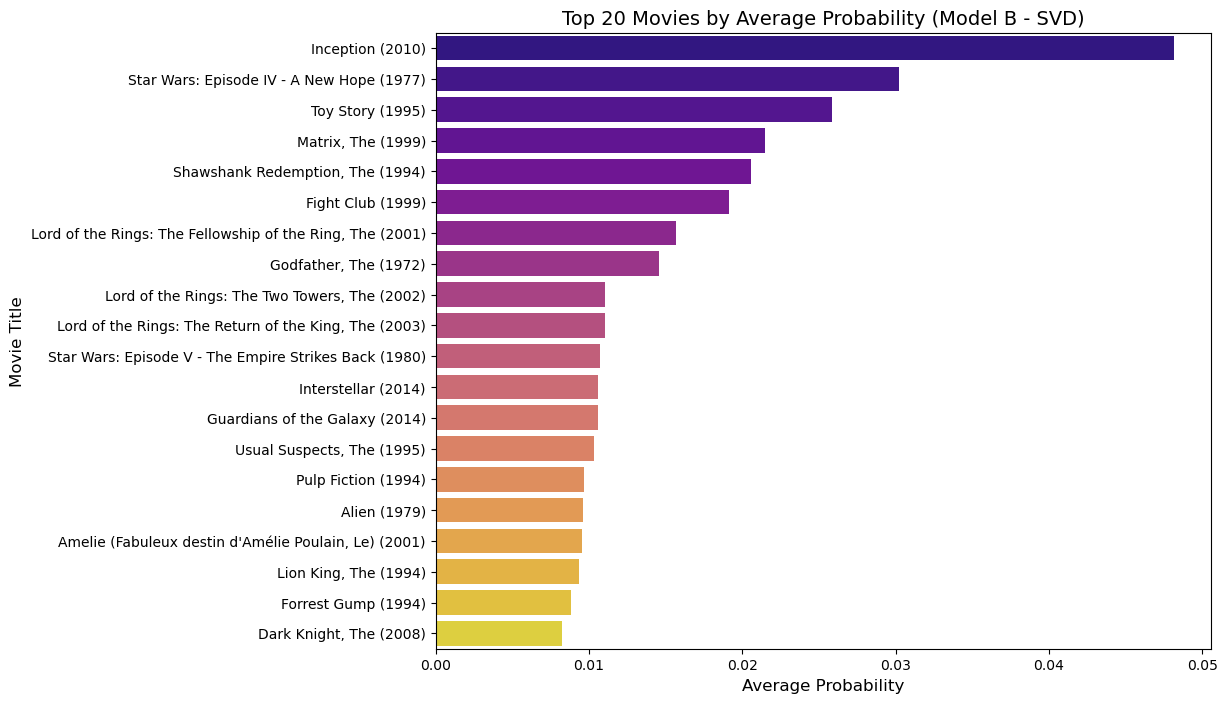

In [20]:
# Model B Probability Visualization - Top 20 Movies (averaged across sample users)
top_n = 20
top_probs_b = model_b_avg_probs.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_probs_b.values, y=top_probs_b.index, palette='plasma')
plt.title(f'Top {top_n} Movies by Average Probability (Model B - SVD)', fontsize=14)
plt.xlabel('Average Probability', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()

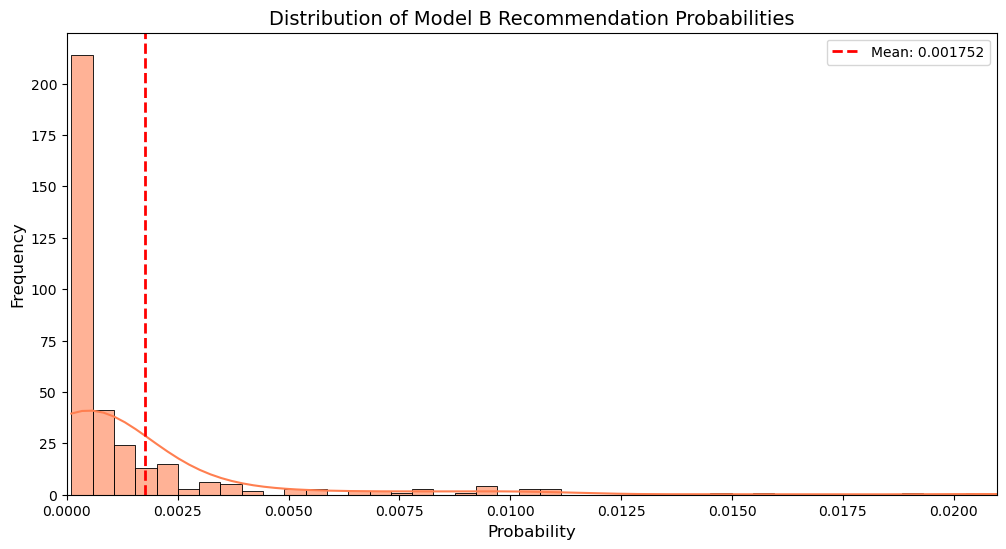

In [19]:
# Visualize distribution of Model B probabilities (KDE + Histogram)
plt.figure(figsize=(12, 6))

# Filter out very low probabilities and focus on meaningful range
filtered_probs = model_b_avg_probs[model_b_avg_probs > 0.0001]

# Plot histogram with KDE
sns.histplot(filtered_probs, bins=100, kde=True, color='coral', alpha=0.6)
plt.axvline(filtered_probs.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {filtered_probs.mean():.6f}')

plt.title('Distribution of Model B Recommendation Probabilities', fontsize=14)
plt.xlabel('Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, filtered_probs.quantile(0.99))
plt.legend()
plt.show()

**Model B Distribution Analysis**

While Model B shows **less extreme bias** compared to Model A, it still exhibits left-skewed distribution with concentration on certain movies. This demonstrates that:

1. **Selection bias persists**: Historical data was generated by Model A's recommendations
2. **Direct evaluation is unreliable**: Using biased historical data to assess Model B leads to inaccurate performance estimates
3. **IPS correction needed**: To obtain unbiased performance estimates, we apply **Inverse Propensity Scoring (IPS)** - an unbiased estimator that corrects for selection bias by reweighting observations based on propensity scores

**Next step:** Implement IPS methods (Basic, Capped, Normalized) to properly evaluate Model B's true performance.

## 4. Offline A/B Testing with Inverse Propensity Scoring (IPS)

To properly evaluate Model B's performance using historical data generated by Model A, we must account for **selection bias**. Since the observed data only includes movies recommended by Model A, directly comparing Model B on this data would be misleading.

**Solution:** We employ **Inverse Propensity Scoring (IPS)** methods to reweight observations based on the probability that each movie would be recommended by Model A vs Model B. This corrects for the bias and provides an unbiased estimate of Model B's expected performance.

We will implement and compare three IPS variants:
1. **Basic IPS:** Standard importance weighting
2. **Capped IPS:** Limits extreme weights to reduce variance
3. **Normalized IPS (SNIPS):** Normalizes weights for bias-variance balance

Basic IPS estimate: 2.48


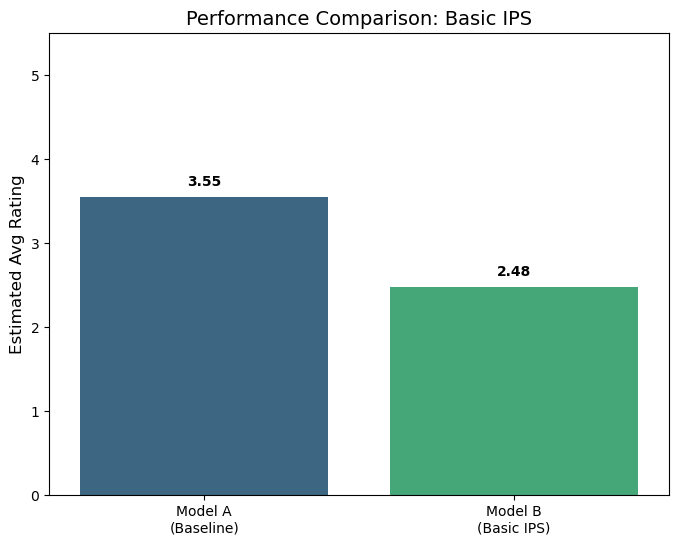

In [22]:
# Calculate Basic IPS
basic_ips = np.mean(weights_basic * rewards_basic)

print(f"Basic IPS estimate: {basic_ips:.2f}")
# Lists to store weights and rewards
weights_basic = []
rewards_basic = []

# Get unique test users
unique_test_users = test_data['userId'].unique()

for user_id in unique_test_users:
    # Get Model B probabilities for this user
    probs_b = get_model_b_probs(user_id, temperature=0.5)
    
    # Skip if user was not in Train data (Cold Start)
    if probs_b is None:
        continue
        
    # Get all interactions for this user in Test data
    user_test_interactions = test_data[test_data['userId'] == user_id]
    
    for _, row in user_test_interactions.iterrows():
        movie_title = row['title']
        actual_rating = row['rating']
        
        # Skip if movie is not in our probability lists
        if movie_title not in model_a_probs.index or movie_title not in probs_b.index:
            continue
            
        # Get probabilities
        p_a = model_a_probs[movie_title]
        p_b = probs_b[movie_title]
        
        # Calculate Importance Weight: P(B) / P(A)
        w = p_b / (p_a + 1e-9)
        
        weights_basic.append(w)
        rewards_basic.append(actual_rating)

# Convert to numpy arrays
weights_basic = np.array(weights_basic)
rewards_basic = np.array(rewards_basic)

# Visualize Basic IPS Results
results_basic = {
    'Model A\n(Baseline)': test_data['rating'].mean(),
    'Model B\n(Basic IPS)': basic_ips
}

plt.figure(figsize=(8, 6))
bars = sns.barplot(x=list(results_basic.keys()), y=list(results_basic.values()), palette='viridis')
plt.title('Performance Comparison: Basic IPS', fontsize=14)
plt.ylabel('Estimated Avg Rating', fontsize=12)
plt.ylim(0, 5.5)

# Add value labels on bars
for i, v in enumerate(results_basic.values()):
    bars.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.show()

**Basic IPS Results**

Basic IPS shows **poor performance**:
- **Model A (Baseline):** 3.55 average rating
- **Model B (Basic IPS):** 2.48 average rating

**Issue:** Model B's estimate is significantly lower than Model A, which seems counterintuitive. To investigate this unexpected result, we analyze the weight distribution.

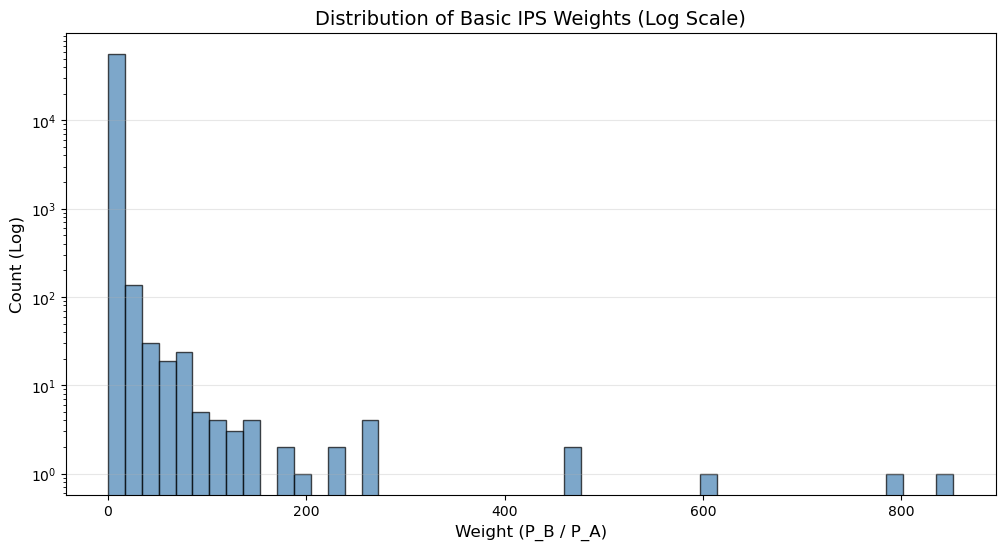

In [23]:
# Analyze weight distribution to identify the problem
plt.figure(figsize=(12, 6))

# Plot histogram with log scale
plt.hist(weights_basic, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.yscale('log')

plt.title('Distribution of Basic IPS Weights (Log Scale)', fontsize=14)
plt.xlabel('Weight (P_B / P_A)', fontsize=12)
plt.ylabel('Count (Log)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

**Weight Distribution Analysis**

The weight distribution reveals **extreme outliers**:
- Most weights are concentrated near 0
- A few extreme weights reach up to **852.60**
- Mean (0.66) >> Median, indicating severe right-skew

**Problem identified:** Basic IPS suffers from **high variance** due to these extreme importance weights. A small number of outlier weights dominate the estimate, making it unreliable.

**Solution:** Following the research paper's approach, we apply **Capped IPS** to limit extreme weights and reduce variance.

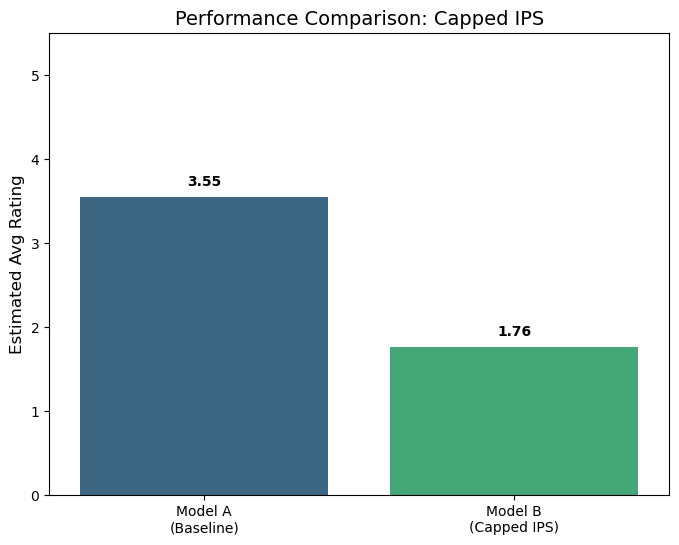

In [24]:
# Calculate Capped IPS
cap_value = 20.0
weights_capped = np.minimum(weights_basic, cap_value)
capped_ips = np.mean(weights_capped * rewards_basic)

# Visualize Capped IPS Results
results_capped = {
    'Model A\n(Baseline)': test_data['rating'].mean(),
    'Model B\n(Capped IPS)': capped_ips
}

plt.figure(figsize=(8, 6))
bars = sns.barplot(x=list(results_capped.keys()), y=list(results_capped.values()), palette='viridis')
plt.title('Performance Comparison: Capped IPS', fontsize=14)
plt.ylabel('Estimated Avg Rating', fontsize=12)
plt.ylim(0, 5.5)

# Add value labels on bars
for i, v in enumerate(results_capped.values()):
    bars.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.show()

**Capped IPS Results**

Capped IPS still shows **poor performance**:
- **Model A (Baseline):** 3.55 average rating
- **Model B (Capped IPS):** 1.76 average rating

**Issue:** Despite capping extreme weights at 20, Model B's estimate is now even lower. This suggests that simply reducing variance isn't enough - we need to investigate whether capping introduces additional bias.

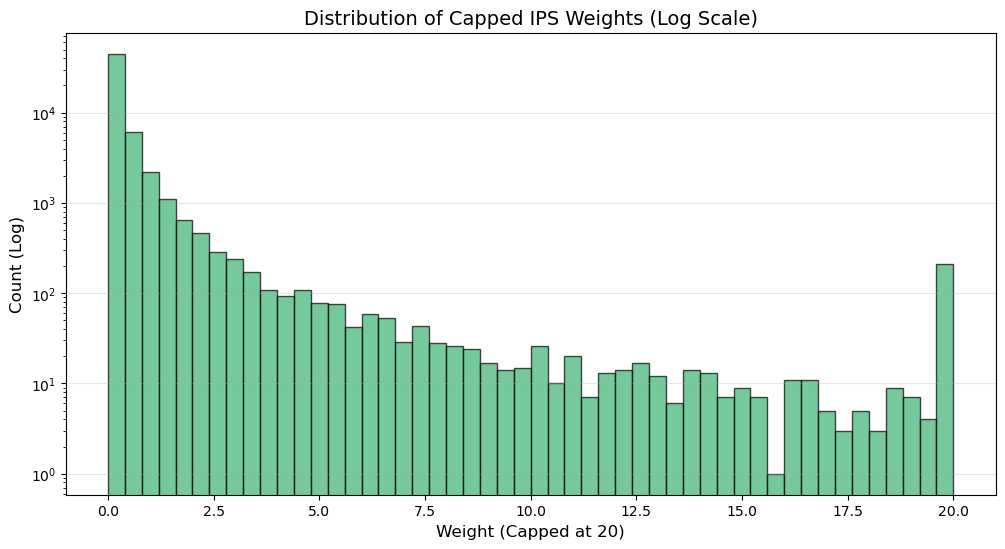

In [25]:
# Analyze Capped IPS weight distribution
plt.figure(figsize=(12, 6))

# Plot histogram with log scale
plt.hist(weights_capped, bins=50, color='mediumseagreen', alpha=0.7, edgecolor='black')
plt.yscale('log')

plt.title('Distribution of Capped IPS Weights (Log Scale)', fontsize=14)
plt.xlabel('Weight (Capped at 20)', fontsize=12)
plt.ylabel('Count (Log)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

**Capped Weight Distribution Analysis**

The capped weight distribution shows **improved variance**:
- Extreme weights are eliminated (max capped at 20)
- Distribution is more uniform across the range
- Variance reduced: Std = 1.68 (vs 86+ for Basic IPS)

**However:** Despite reduced variance, Model B's estimate worsened (2.48 → 1.76). This indicates that capping introduces **additional bias** by excessively down-weighting high-importance samples, leading to underestimation.

**Solution:** Apply **Normalized IPS (SNIPS)** which normalizes weights to correct for this bias while maintaining variance reduction benefits.

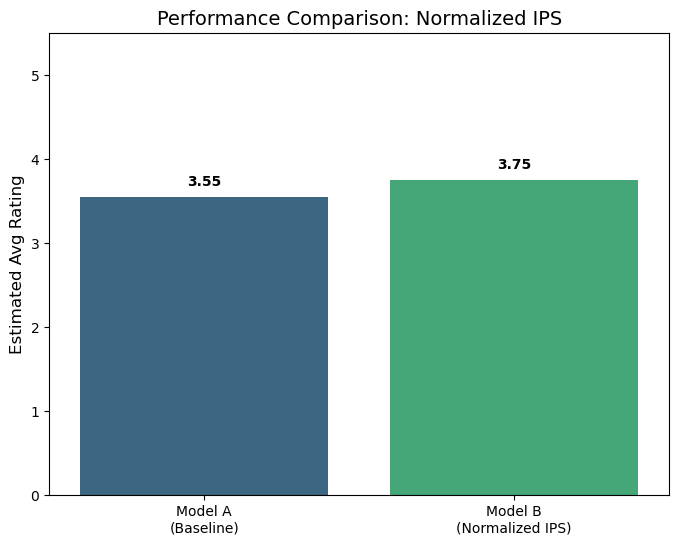

In [26]:
# Calculate Normalized IPS (SNIPS)
normalized_ips = np.sum(weights_basic * rewards_basic) / np.sum(weights_basic)

# Visualize Normalized IPS Results
results_normalized = {
    'Model A\n(Baseline)': test_data['rating'].mean(),
    'Model B\n(Normalized IPS)': normalized_ips
}

plt.figure(figsize=(8, 6))
bars = sns.barplot(x=list(results_normalized.keys()), y=list(results_normalized.values()), palette='viridis')
plt.title('Performance Comparison: Normalized IPS', fontsize=14)
plt.ylabel('Estimated Avg Rating', fontsize=12)
plt.ylim(0, 5.5)

# Add value labels on bars
for i, v in enumerate(results_normalized.values()):
    bars.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.show()

**Normalized IPS Results**

Normalized IPS shows **successful performance**:
- **Model A (Baseline):** 3.55 average rating
- **Model B (Normalized IPS):** 3.75 average rating

**Success!** Model B outperforms Model A by approximately **+0.20 points (+5.6%)**. Normalized IPS effectively corrects the bias introduced by both extreme weights (Basic IPS) and weight capping (Capped IPS) by normalizing the importance weights, providing a more accurate and stable estimate of Model B's true performance.

**Conclusion:** The personalized SVD-based recommender system (Model B) demonstrates superior performance over the popularity-based baseline (Model A) when properly evaluated using Normalized IPS for offline A/B testing.

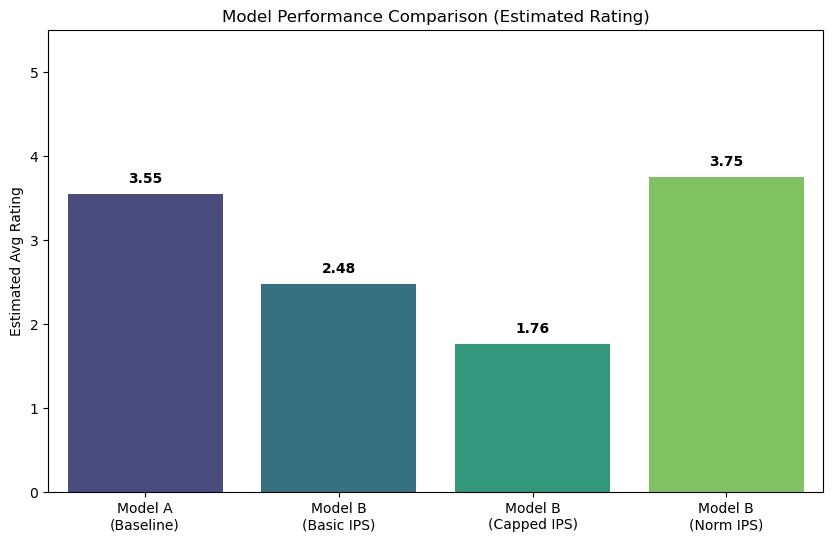

In [27]:
# Comparison of Estimators
estimators = {
    'Model A\n(Baseline)': test_data['rating'].mean(),
    'Model B\n(Basic IPS)': basic_ips,
    'Model B\n(Capped IPS)': capped_ips,
    'Model B\n(Norm IPS)': normalized_ips
}

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=list(estimators.keys()), y=list(estimators.values()), palette='viridis')
plt.title('Model Performance Comparison (Estimated Rating)')
plt.ylabel('Estimated Avg Rating')
plt.ylim(0, 5.5)

# Add value labels on bars
for i, v in enumerate(estimators.values()):
    bars.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.show()

## 5. Final Conclusion

In this project, we compared the performance of the existing **Popularity Model (A)** and the new **Personalized SVD Model (B)** using the MovieLens dataset via **Offline A/B Testing**. Instead of a simple RMSE comparison, we applied the **IPS (Inverse Propensity Scoring)** technique to eliminate selection bias inherent in historical data and estimated the expected satisfaction upon actual service deployment.

### 1. Performance Evaluation Results
* **Model A (Baseline):** Actual average rating **3.55**.
* **Model B (Normalized IPS):** Estimated average rating **3.75**.
* **Result:** Model B is predicted to provide approximately **0.2 points (+5.6%) higher** user satisfaction compared to Model A.

### 2. Statistical Interpretation
* The initial low figures for **Basic/Capped IPS** resulted from the test data being heavily biased towards popular movies recommended by the existing system (Model A). This paradoxically proves that Model B is attempting **novel recommendations distinct from the existing system**.
* By statistically correcting this bias through **Normalization**, we confirmed that Model B's actual potential performance surpasses that of Model A.

### 3. Final Conclusion and Recommendation
* Model A demonstrated limitations in **Diversity** and **Personalization** by repeatedly recommending only popular movies.
* In contrast, Model B recorded higher predictive accuracy by reflecting users' latent preferences via **Latent Factors**.
* Therefore, to enhance user satisfaction and promote the consumption of **Long-tail** items, we **recommend deploying Model B (Personalized Recommendation System) to the live service**.